In [12]:
import sys
sys.path.append("../") 
import databasepopulation
import communicationwmongo as commu
import home_location as home
import analysis as a
import pymongo
import my_h3_functions as myh3
import geopandas as gpd
import pandas as pd
import numpy as np
from h3 import h3

# 0. Connect to Mongo and define a specific database

In [13]:
db=commu.connecttoLocaldb(database='twitter_hk')

# 1. Obtaining hexcounts from database

In [14]:
import time 
start=time.time()
df=a.hexcountsresults_to_df(db, save=False)
print(time.time()-start)

1.6901485919952393


In [15]:
df.head()

,_id,level_1,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,time
0,8941022db2fffff,1404086400000,1.0,1.0,NaN,1.0,2014-06-30
1,89410329417ffff,1372550400000,2.0,2.0,NaN,2.0,2013-06-30
2,8941032d043ffff,1372550400000,1.0,1.0,NaN,1.0,2013-06-30
3,8941032d04bffff,1372550400000,1.0,1.0,NaN,1.0,2013-06-30
4,8941032d207ffff,1419984000000,1.0,1.0,NaN,1.0,2014-12-31


# 2. Divide the sample time period in two and compute time changes

We will divide the period available time period in two, average the counts for the two resulting subperiods, and compute the changes between periods. The result is a dataframe at the hex_id level. The result is also a GeoDataFrame ready to plot

In [16]:
# Tweets are counted in time intervals defined in the tweets counts function. The default is quarterly data. 
# 1. Check first the available dates in the counts
df.time.unique()

array(['2014-06-30T00:00:00.000000000', '2013-06-30T00:00:00.000000000',
       '2014-12-31T00:00:00.000000000', '2013-03-31T00:00:00.000000000',
       '2013-09-30T00:00:00.000000000', '2013-12-31T00:00:00.000000000',
       '2014-03-31T00:00:00.000000000', '2014-09-30T00:00:00.000000000',
       '2012-12-31T00:00:00.000000000', '2016-09-30T00:00:00.000000000',
       '2015-03-31T00:00:00.000000000', '2016-06-30T00:00:00.000000000',
       '2015-09-30T00:00:00.000000000', '2015-06-30T00:00:00.000000000',
       '2012-09-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000',
       '2016-03-31T00:00:00.000000000', '2016-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [17]:
df

,_id,level_1,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,time
0,8941022db2fffff,1404086400000,1.0,1.0,NaN,1.0,2014-06-30
1,89410329417ffff,1372550400000,2.0,2.0,NaN,2.0,2013-06-30
2,8941032d043ffff,1372550400000,1.0,1.0,NaN,1.0,2013-06-30
3,8941032d04bffff,1372550400000,1.0,1.0,NaN,1.0,2013-06-30
4,8941032d207ffff,1419984000000,1.0,1.0,NaN,1.0,2014-12-31
...,...,...,...,...,...,...,...
121758,89411dd70cfffff,1443571200000,NaN,NaN,NaN,0.0,2015-09-30
121759,89411dd70cfffff,1451520000000,NaN,NaN,NaN,0.0,2015-12-31
121760,89411dd70cfffff,1459382400000,NaN,NaN,NaN,0.0,2016-03-31
121761,89411dd7197ffff,1451520000000,NaN,NaN,NaN,0.0,2015-12-31


In [18]:
# 2 Define a midpoint date to separate the two periods in the data. 
import datetime
gdfchanges=a.percent_change_two_periods_df(df, datebeforeandafterperiod=datetime.datetime(2013,6,30))

..\analysis.py:961: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df2dif=df2.groupby('_id')['nonresidents', 'nonresidentsandnonneighbors', 'residents', 'totalcounts'].diff(1)


Coding \ _p0 is the average level of tweets counts in the first period \ _dif is the difference between periods \ _ch stands for % changes \ _chb is an alternative % change only for those hexs with more than 50 tweets.

In [19]:
gdfchanges.head(10)

,_id,nonresidents_dif,nonresidentsandnonneighbors_dif,residents_dif,totalcounts_dif,nonresidents_p0,nonresidentsandnonneighbors_p0,residents_p0,totalcounts_p0,nonresidents_ch,nonresidentsandnonneighbors_ch,residents_ch,totalcounts_ch,nonresidents_chb,nonresidentsandnonneighbors_chb,residents_chb,totalcounts_chb,geometry
0,8941032d22bffff,-0.333333,-0.333333,NaN,-0.333333,0.500000,0.500000,NaN,0.500000,-0.666667,-0.666667,NaN,-0.666667,NaN,NaN,NaN,NaN,"POLYGON ((113.38313 22.02149, 113.38274 22.023..."
1,8941032d23bffff,0.000000,0.000000,NaN,0.000000,0.666667,0.666667,NaN,0.666667,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,"POLYGON ((113.38535 22.01901, 113.38495 22.020..."
2,89410345203ffff,-0.333333,-0.333333,NaN,-0.333333,1.000000,1.000000,NaN,1.000000,-0.333333,-0.333333,NaN,-0.333333,NaN,NaN,NaN,NaN,"POLYGON ((114.02776 22.10516, 114.02737 22.106..."
3,89410345207ffff,-0.444444,-0.444444,NaN,-0.444444,0.666667,0.666667,NaN,0.666667,-0.666667,-0.666667,NaN,-0.666667,NaN,NaN,NaN,NaN,"POLYGON ((114.02452 22.10471, 114.02413 22.106..."
4,89410345217ffff,-6.923077,-6.923077,NaN,-6.923077,9.000000,9.000000,NaN,9.000000,-0.769231,-0.769231,NaN,-0.769231,NaN,NaN,NaN,NaN,"POLYGON ((114.02671 22.10223, 114.02633 22.104..."
5,8941034528bffff,-0.300000,-0.300000,NaN,-0.300000,1.000000,1.000000,NaN,1.000000,-0.300000,-0.300000,NaN,-0.300000,NaN,NaN,NaN,NaN,"POLYGON ((114.03215 22.10019, 114.03177 22.101..."
6,89410348053ffff,-0.484848,-0.484848,NaN,-0.484848,0.666667,0.666667,NaN,0.666667,-0.727273,-0.727273,NaN,-0.727273,NaN,NaN,NaN,NaN,"POLYGON ((114.20043 22.20923, 114.20005 22.211..."
7,8941034806fffff,-0.750000,-0.750000,NaN,-0.750000,1.000000,1.000000,NaN,1.000000,-0.750000,-0.750000,NaN,-0.750000,NaN,NaN,NaN,NaN,"POLYGON ((114.18738 22.21581, 114.18700 22.217..."
8,89410348203ffff,0.173077,0.173077,NaN,-3.326923,0.750000,0.750000,14.0,4.250000,0.230769,0.230769,NaN,-0.782805,NaN,NaN,NaN,NaN,"POLYGON ((114.20021 22.22588, 114.19983 22.227..."
9,89410348207ffff,-5.875000,-4.875000,NaN,-5.875000,7.000000,6.000000,NaN,7.000000,-0.839286,-0.812500,NaN,-0.839286,NaN,NaN,NaN,NaN,"POLYGON ((114.19698 22.22544, 114.19659 22.227..."


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

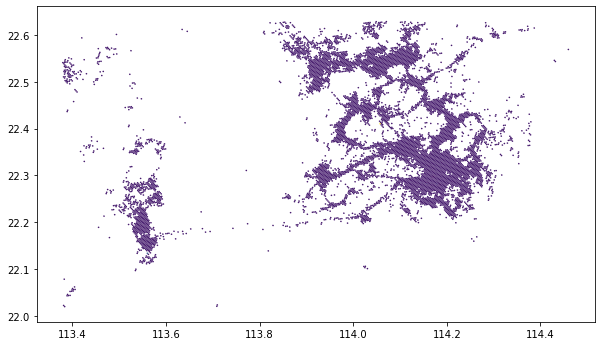

In [20]:
# Plot example
gdfchanges.plot('nonresidents_dif')
gdfchanges.crs

## 3. Spatial join with census tracks (typologies) data

This requires:

    An available function changes the geometry of the gdf to the centroids
    Load your typologies data to a geodataframe
    Spatial join

In [21]:
#1 Get centroids
gdfchanges_points = myh3.df_with_hexid_to_centroids_gdf(gdfchanges, hexcolname='_id')

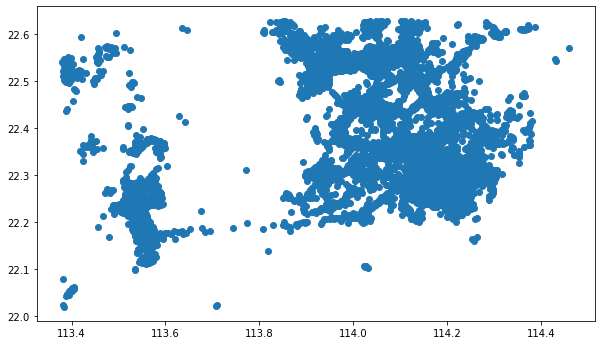

In [22]:
gdfchanges_points.plot()

In [23]:
# Load your typologies data as a geodataframe 
from pathlib import Path, PureWindowsPath
shp_path = Path("../../../../Box/Twitter data/Observation Shapefiles")

tracts = gpd.read_file(shp_path/"hk.geojson")
tracts = tracts.to_crs({'init': 'epsg:4326'})

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

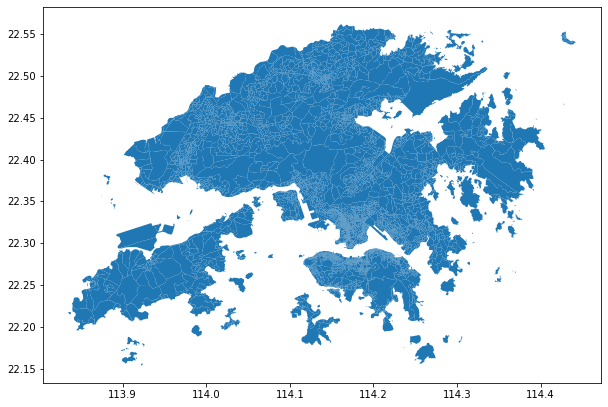

In [24]:
tracts.plot()
tracts.crs

In [25]:
# # 3 Spatial Join between centroids and census track shapes
tweets_tracts=gpd.sjoin(gdfchanges_points, tracts, how="inner", op='intersects')

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != +init=epsg:4326 +type=crs)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [26]:
tweets_tracts.head()

,_id,nonresidents_dif,nonresidentsandnonneighbors_dif,residents_dif,totalcounts_dif,nonresidents_p0,nonresidentsandnonneighbors_p0,residents_p0,totalcounts_p0,nonresidents_ch,...,TPU,SB_VC,TYPE_Eng,TYPE_TC,TYPE_SC,Shape_Length,Shape_Area,category,label,standardized_types
7,8941034806fffff,-0.750000,-0.750000,NaN,-0.750000,1.000000,1.000000,NaN,1.000000,-0.750000,...,193,4,Street Blocks,街段統計區,街段统计区,2034.498942,126925.175917,6,No Category,Other
8,89410348203ffff,0.173077,0.173077,NaN,-3.326923,0.750000,0.750000,14.00,4.250000,0.230769,...,192,15,Street Blocks,街段統計區,街段统计区,6235.958952,785764.254109,1,Not Currently at Risk of Displacement,"Low Income, Stable"
10,8941034820bffff,157.142857,-0.928571,40.000000,178.178571,9.000000,8.000000,4.25,13.250000,17.460317,...,192,15,Street Blocks,街段統計區,街段统计区,6235.958952,785764.254109,1,Not Currently at Risk of Displacement,"Low Income, Stable"
12,89410348213ffff,-0.133333,-0.133333,NaN,-0.133333,0.333333,0.333333,NaN,0.333333,-0.400000,...,192,15,Street Blocks,街段統計區,街段统计区,6235.958952,785764.254109,1,Not Currently at Risk of Displacement,"Low Income, Stable"
13,89410348217ffff,-4.821429,-4.821429,-0.634615,-5.500000,16.250000,16.250000,1.25,17.500000,-0.296703,...,192,15,Street Blocks,街段統計區,街段统计区,6235.958952,785764.254109,1,Not Currently at Risk of Displacement,"Low Income, Stable"


In [27]:
typo_stats = tweets_tracts[['nonresidents_dif','nonresidents_ch', 'nonresidents_p0', 'standardized_types']].groupby('standardized_types').agg(['mean','count','sem'])
#nonresidents_p0
typo_stats

nonresidents_dif                   \
                                          mean count        sem   
standardized_types                                                
Exclusive Static                     -6.143992   428   5.543964   
Low Income, At Risk of Change       -18.278802   406   7.864282   
Low Income, Stable                  -21.105953  1467   3.572108   
Low Income, Undergoing Change        -8.819650   214   9.089246   
Other                                 8.037691  1256  28.602530   

                              nonresidents_ch                   \
                                         mean count        sem   
standardized_types                                               
Exclusive Static                     0.382966   428   0.185206   
Low Income, At Risk of Change       19.606278   406  19.463648   
Low Income, Stable                   1.166779  1467   0.630187   
Low Income, Undergoing Change        0.171458   214   0.327795   
Other                               28.649255  1256  28.478650   

                              nonresidents_p0                   
                                         mean count        sem  
standardized_types                                              
Exclusive Static                    44.090148   428  10.033933  
Low Income, At Risk of Change       61.606527   406   9.818478  
Low Income, Stable                  55.717394  1467   6.690936  
Low Income, Undergoing Change       34.358645   214  11.016337  
Other                               52.630801  1257   4.466030

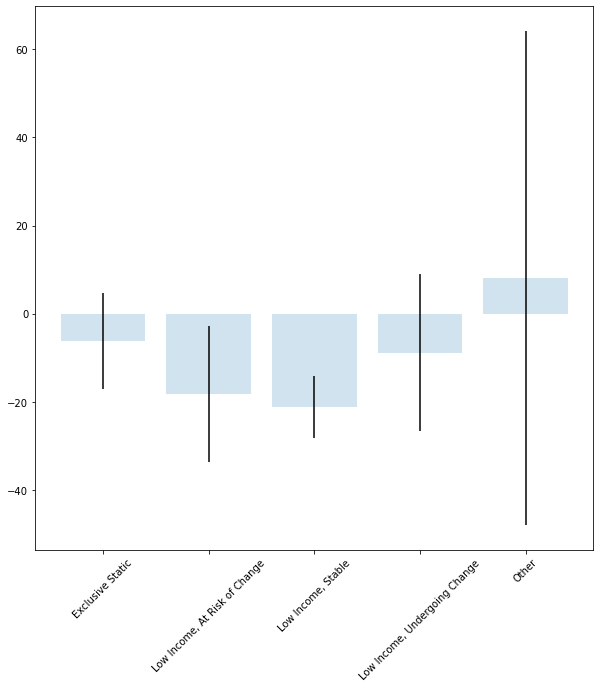

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(typo_stats.index, typo_stats['nonresidents_dif','mean'], yerr=1.96*typo_stats['nonresidents_dif','sem'], alpha=0.2)
plt.xticks(rotation=45)
plt.show()

In [30]:
import matplotlib.pyplot as plt

def barchart(tweets_tracts, metric, title):
    
    #Windsorizing series to tream outliers 
    tweets_tracts['nonresidents_dif']=tweets_tracts['nonresidents_dif'].clip(lower= -60, upper=1000)
    tweets_tracts['nonresidents_ch']=tweets_tracts['nonresidents_ch'].clip(upper=6)
    
    #tweets_tracts['nonresidents_ch'].hist()
    typo_stats=tweets_tracts[['nonresidents_dif','nonresidents_ch', 'nonresidents_p0', 'standardized_types']].groupby('standardized_types').agg(['mean','count','sem','std'])
    
    typo_stats=typo_stats.reset_index()
    
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='NON_POP']
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='NON POP']
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='OTHER']
    
    
    #Sorting 
    typo_stats=typo_stats.sort_values(by=(metric,'mean'), ascending=False)
    
    fig, ax = plt.subplots()
    ax.bar(typo_stats['standardized_types'], typo_stats[metric,'mean'], yerr=1.96*typo_stats[metric,'sem'], alpha=0.2)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

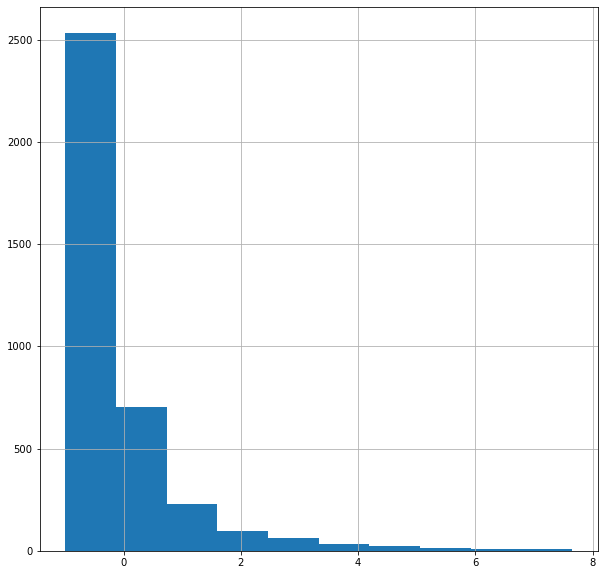

In [31]:
tweets_tracts.loc[tweets_tracts.nonresidents_ch<8].nonresidents_ch.hist()

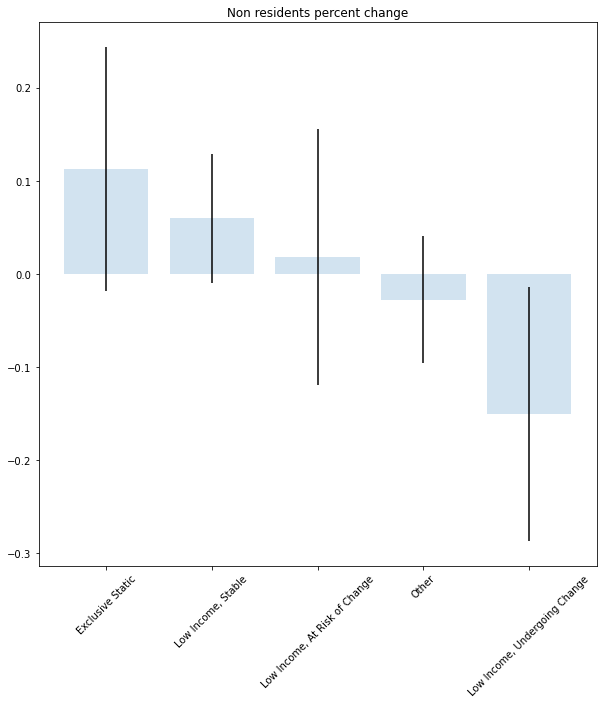

In [32]:
barchart(tweets_tracts, 'nonresidents_ch', title="Non residents percent change")

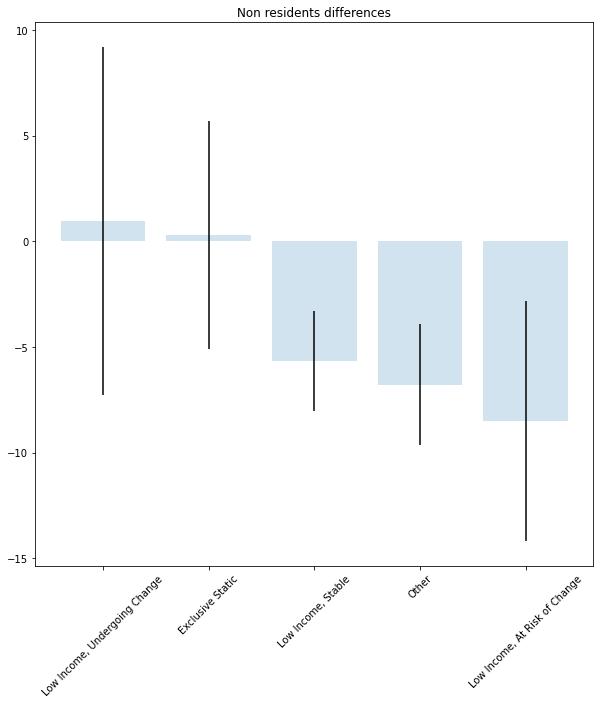

In [33]:
barchart(tweets_tracts, 'nonresidents_dif', title="Non residents differences")